In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = f"F:/Git Hub rep/PyBaMM/gmproj/data/esoh_R/"
oCV_DIR = f"F:/Git Hub rep/PyBaMM/gmproj/data/OCV/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
# parameter_values = get_parameter_values()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

parameter_values.update(
    {
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
#         # Initializing Particle Concentration
#         # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
#         # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("radius")

Negative particle radius [m]	1e-05
Positive particle radius [m]	3.5e-06


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

In [5]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
# "Electrode width [m]":0.2,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
# "Nominal cell capacity [A.h]":5,
# "Maximum concentration in positive electrode [mol.m-3]":37500,
        
# Updating since February 2022        
# "Negative electrode porosity":0.3,
# "Positive electrode thickness [m]":5.45e-05,
# "Electrode width [m]" : 0.11,      
     
    }
)

In [6]:
cell = 22

In [7]:
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp


45

In [8]:
eps_n_data

0.5702698483821774

In [9]:
 parameter_values.search("Reference temperature")

Reference temperature [K]	298.15


In [10]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min",)
    ] *900,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment2 = pybamm.Experiment(
    [
        ("Rest for 24 hours",)
    ] *150,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment3 = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/20",
         "Rest for 10 min",
         "Discharge at 1C until 3.7V",
         "Rest for 80 min",)
    ] *800,
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment4 = pybamm.Experiment(
    [
        ("Rest for 24 hours",
)
    ] *200,
    termination="50% capacity",
#     cccv_handling="ode",
)


eps_p_data

0.4158236292522722

In [11]:
# Temp=45
# Temp=25

In [12]:
# parameter_values = get_parameter_values()
parameter_values.update(
 u8   {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
#         "Positive electrode LAM constant proportional term [s-1]": 8.3747149e-08,#1.27152e-07
        "Positive electrode LAM constant proportional term [s-1]": 7.6504e-08,#10.0638e-08, #8e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":8.7598e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]": 4.61e-16, #4.1964e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.57e-19, #6.6582e-19, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87e4, #6.02602e+03, #1.87422275e+04,1.58777981e+04,
#         "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 1.3e03,    #1e06, #3.0e+05,
        "Lithium plating kinetic rate constant [m.s-1]":4.639e-10, #4.50936e-10,
        
        #Cathode disolution
#         "Positive electrode dissolution exchange current density": 6.243219e-4,
        "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        
        
    },
    check_already_exists=False,
)

In [13]:
# sim_long3 = pybamm.Simulation(spm, experiment=experiment3, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long3 = sim_long3.solve(initial_soc=0.5, save_at_cycles=20  )


In [13]:
 parameter_values.search("area")

Cell cooling surface area [m2]	0.41


In [15]:
# sim_long3.plot(
#     [
# #         "Negative particle surface concentration [mol.m-3]",
# #         "Electrolyte concentration [mol.m-3]",
#         "Positive particle surface concentration [mol.m-3]",
#         "Current [A]",
# #         "Negative electrode potential [V]",
# #         "Electrolyte potential [V]",
# #         "Positive electrode potential [V]",
#         "Terminal voltage [V]",
# #         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"

#     ]
# )

In [16]:
# pybamm.plot_summary_variables(sol_long3)

In [17]:
# summary_long3=sol_long3.summary_varabales

In [14]:
sim_long1 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long1 = sim_long1.solve(initial_soc=1, save_at_cycles=20  )

2023-04-06 18:35:20.802 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/200 (20.043 ms elapsed) --------------------
2023-04-06 18:35:20.803 - [NOTICE] callbacks.on_step_start(182): Cycle 1/200, step 1/1: Rest for 24 hours
2023-04-06 18:35:23.271 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.636 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:35:23.271 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/200 (2.490 s elapsed) --------------------
2023-04-06 18:35:23.273 - [NOTICE] callbacks.on_step_start(182): Cycle 2/200, step 1/1: Rest for 24 hours
2023-04-06 18:35:25.440 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.630 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:35:25.441 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/200 (4.659 s elapsed) --------------------
2023-04-06 18:35:25.442 - [NOTICE] callbacks.on_step_start(182): Cycle 3/200, step 1/1: Rest for 24 hours
2023-04-06 18:35:27.725 - [NOTICE] callbacks.on_cycle_end(196

2023-04-06 18:36:14.339 - [NOTICE] callbacks.on_cycle_start(174): Cycle 24/200 (53.557 s elapsed) --------------------
2023-04-06 18:36:14.339 - [NOTICE] callbacks.on_step_start(182): Cycle 24/200, step 1/1: Rest for 24 hours
2023-04-06 18:36:16.746 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.485 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:36:16.746 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/200 (55.970 s elapsed) --------------------
2023-04-06 18:36:16.746 - [NOTICE] callbacks.on_step_start(182): Cycle 25/200, step 1/1: Rest for 24 hours
2023-04-06 18:36:19.118 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.478 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:36:19.120 - [NOTICE] callbacks.on_cycle_start(174): Cycle 26/200 (58.339 s elapsed) --------------------
2023-04-06 18:36:19.120 - [NOTICE] callbacks.on_step_start(182): Cycle 26/200, step 1/1: Rest for 24 hours
2023-04-06 18:36:21.382 - [NOTICE] callbacks.on_cycle_

2023-04-06 18:37:02.749 - [NOTICE] callbacks.on_step_start(182): Cycle 46/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:04.910 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.341 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:37:04.918 - [NOTICE] callbacks.on_cycle_start(174): Cycle 47/200 (1 minute, 44 seconds elapsed) --------------------
2023-04-06 18:37:04.918 - [NOTICE] callbacks.on_step_start(182): Cycle 47/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:07.405 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.334 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:37:07.405 - [NOTICE] callbacks.on_cycle_start(174): Cycle 48/200 (1 minute, 47 seconds elapsed) --------------------
2023-04-06 18:37:07.405 - [NOTICE] callbacks.on_step_start(182): Cycle 48/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:09.542 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.328 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:3

2023-04-06 18:37:51.072 - [NOTICE] callbacks.on_step_start(182): Cycle 68/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:53.194 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.203 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:37:53.202 - [NOTICE] callbacks.on_cycle_start(174): Cycle 69/200 (2 minutes, 32 seconds elapsed) --------------------
2023-04-06 18:37:53.202 - [NOTICE] callbacks.on_step_start(182): Cycle 69/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:55.365 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.197 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:37:55.365 - [NOTICE] callbacks.on_cycle_start(174): Cycle 70/200 (2 minutes, 35 seconds elapsed) --------------------
2023-04-06 18:37:55.365 - [NOTICE] callbacks.on_step_start(182): Cycle 70/200, step 1/1: Rest for 24 hours
2023-04-06 18:37:57.505 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.191 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18

2023-04-06 18:38:38.901 - [NOTICE] callbacks.on_step_start(182): Cycle 90/200, step 1/1: Rest for 24 hours
2023-04-06 18:38:41.320 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.071 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:38:41.328 - [NOTICE] callbacks.on_cycle_start(174): Cycle 91/200 (3 minutes, 21 seconds elapsed) --------------------
2023-04-06 18:38:41.328 - [NOTICE] callbacks.on_step_start(182): Cycle 91/200, step 1/1: Rest for 24 hours
2023-04-06 18:38:43.446 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.065 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:38:43.446 - [NOTICE] callbacks.on_cycle_start(174): Cycle 92/200 (3 minutes, 23 seconds elapsed) --------------------
2023-04-06 18:38:43.446 - [NOTICE] callbacks.on_step_start(182): Cycle 92/200, step 1/1: Rest for 24 hours
2023-04-06 18:38:45.608 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.059 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18

2023-04-06 18:39:27.162 - [NOTICE] callbacks.on_step_start(182): Cycle 112/200, step 1/1: Rest for 24 hours
2023-04-06 18:39:29.326 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.944 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:39:29.326 - [NOTICE] callbacks.on_cycle_start(174): Cycle 113/200 (4 minutes, 9 seconds elapsed) --------------------
2023-04-06 18:39:29.326 - [NOTICE] callbacks.on_step_start(182): Cycle 113/200, step 1/1: Rest for 24 hours
2023-04-06 18:39:31.470 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.938 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:39:31.470 - [NOTICE] callbacks.on_cycle_start(174): Cycle 114/200 (4 minutes, 11 seconds elapsed) --------------------
2023-04-06 18:39:31.479 - [NOTICE] callbacks.on_step_start(182): Cycle 114/200, step 1/1: Rest for 24 hours
2023-04-06 18:39:33.589 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.933 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-0

2023-04-06 18:40:15.312 - [NOTICE] callbacks.on_step_start(182): Cycle 134/200, step 1/1: Rest for 24 hours
2023-04-06 18:40:17.422 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.822 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:40:17.422 - [NOTICE] callbacks.on_cycle_start(174): Cycle 135/200 (4 minutes, 57 seconds elapsed) --------------------
2023-04-06 18:40:17.422 - [NOTICE] callbacks.on_step_start(182): Cycle 135/200, step 1/1: Rest for 24 hours
2023-04-06 18:40:19.575 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.816 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:40:19.575 - [NOTICE] callbacks.on_cycle_start(174): Cycle 136/200 (4 minutes, 59 seconds elapsed) --------------------
2023-04-06 18:40:19.583 - [NOTICE] callbacks.on_step_start(182): Cycle 136/200, step 1/1: Rest for 24 hours
2023-04-06 18:40:21.706 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.811 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-

2023-04-06 18:41:07.185 - [NOTICE] callbacks.on_step_start(182): Cycle 156/200, step 1/1: Rest for 24 hours
2023-04-06 18:41:09.344 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.704 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:41:09.346 - [NOTICE] callbacks.on_cycle_start(174): Cycle 157/200 (5 minutes, 47 seconds elapsed) --------------------
2023-04-06 18:41:09.346 - [NOTICE] callbacks.on_step_start(182): Cycle 157/200, step 1/1: Rest for 24 hours
2023-04-06 18:41:11.543 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.698 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:41:11.543 - [NOTICE] callbacks.on_cycle_start(174): Cycle 158/200 (5 minutes, 49 seconds elapsed) --------------------
2023-04-06 18:41:11.553 - [NOTICE] callbacks.on_step_start(182): Cycle 158/200, step 1/1: Rest for 24 hours
2023-04-06 18:41:14.082 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.693 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-

2023-04-06 18:41:56.595 - [NOTICE] callbacks.on_step_start(182): Cycle 178/200, step 1/1: Rest for 24 hours
2023-04-06 18:41:58.772 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.589 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:41:58.772 - [NOTICE] callbacks.on_cycle_start(174): Cycle 179/200 (6 minutes, 37 seconds elapsed) --------------------
2023-04-06 18:41:58.772 - [NOTICE] callbacks.on_step_start(182): Cycle 179/200, step 1/1: Rest for 24 hours
2023-04-06 18:42:00.954 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.584 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:42:00.954 - [NOTICE] callbacks.on_cycle_start(174): Cycle 180/200 (6 minutes, 39 seconds elapsed) --------------------
2023-04-06 18:42:00.954 - [NOTICE] callbacks.on_step_start(182): Cycle 180/200, step 1/1: Rest for 24 hours
2023-04-06 18:42:03.324 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.579 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-

2023-04-06 18:42:46.148 - [NOTICE] callbacks.on_step_start(182): Cycle 200/200, step 1/1: Rest for 24 hours
2023-04-06 18:42:48.295 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.478 Ah (originally 4.636 Ah, will stop at 2.318 Ah)
2023-04-06 18:42:48.303 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 7 minutes, 26 seconds


In [15]:
sim_long1.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
          "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
#         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"
#         "Loss of active material in positive electrode [%]",
#         "X-averaged positive electrode active material volume fraction change",
#         "Positive particle surface concentration",
#         "R-averaged positive particle concentration",
#         "Positive electrode surface potential difference",
#         "Positive electrode surface potential difference [V]"

        



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=4799.999999999975, step=47.99999999999975), …

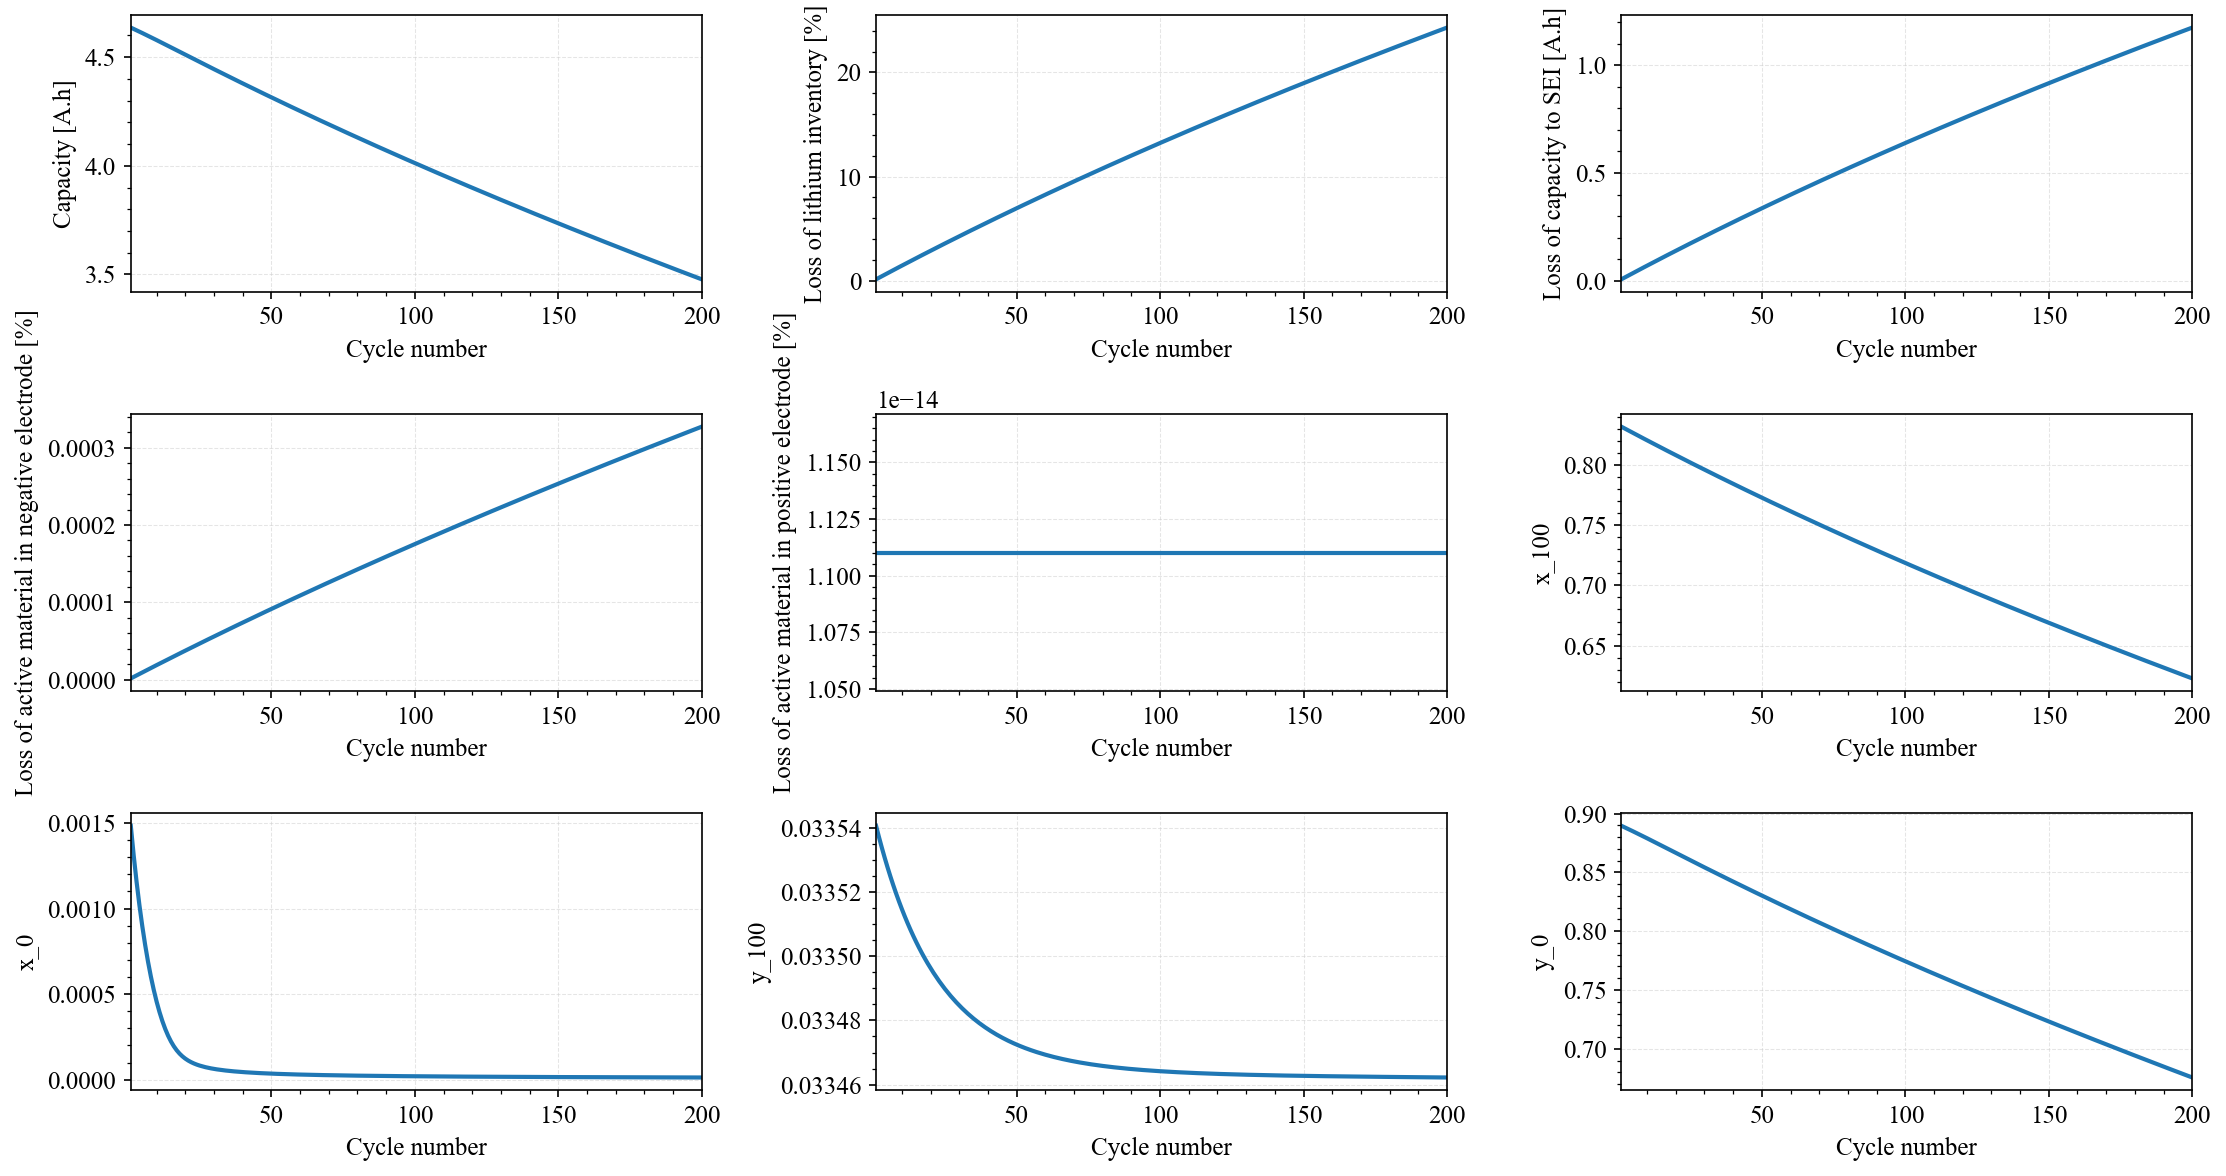

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [16]:
pybamm.plot_summary_variables(sol_long1)

In [21]:
spm.param.timescale

Division(0x237f06ca73c12ae7, /, children=['96485.33212 * Maximum concentration in negative electrode [mol.m-3] * (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m])', 'absolute(Typical current [A] / (Number of electrodes connected in parallel to make a cell * Electrode width [m] * Electrode height [m]))'], domains={})

In [17]:
sim_long11 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long11 = sim_long11.solve(initial_soc=0.5, save_at_cycles=20  )

2023-04-06 19:06:42.582 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/200 (21.835 ms elapsed) --------------------
2023-04-06 19:06:42.584 - [NOTICE] callbacks.on_step_start(182): Cycle 1/200, step 1/1: Rest for 24 hours
2023-04-06 19:06:45.225 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.639 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:06:45.226 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/200 (2.665 s elapsed) --------------------
2023-04-06 19:06:45.226 - [NOTICE] callbacks.on_step_start(182): Cycle 2/200, step 1/1: Rest for 24 hours
2023-04-06 19:06:47.512 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.635 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:06:47.513 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/200 (4.953 s elapsed) --------------------
2023-04-06 19:06:47.514 - [NOTICE] callbacks.on_step_start(182): Cycle 3/200, step 1/1: Rest for 24 hours
2023-04-06 19:06:49.839 - [NOTICE] callbacks.on_cycle_end(196

2023-04-06 19:07:37.039 - [NOTICE] callbacks.on_cycle_start(174): Cycle 24/200 (54.478 s elapsed) --------------------
2023-04-06 19:07:37.040 - [NOTICE] callbacks.on_step_start(182): Cycle 24/200, step 1/1: Rest for 24 hours
2023-04-06 19:07:39.367 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.554 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:07:39.368 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/200 (56.807 s elapsed) --------------------
2023-04-06 19:07:39.368 - [NOTICE] callbacks.on_step_start(182): Cycle 25/200, step 1/1: Rest for 24 hours
2023-04-06 19:07:42.222 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.550 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:07:42.223 - [NOTICE] callbacks.on_cycle_start(174): Cycle 26/200 (59.662 s elapsed) --------------------
2023-04-06 19:07:42.223 - [NOTICE] callbacks.on_step_start(182): Cycle 26/200, step 1/1: Rest for 24 hours
2023-04-06 19:07:44.485 - [NOTICE] callbacks.on_cycle_

2023-04-06 19:08:30.219 - [NOTICE] callbacks.on_step_start(182): Cycle 46/200, step 1/1: Rest for 24 hours
2023-04-06 19:08:32.734 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.468 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:08:32.735 - [NOTICE] callbacks.on_cycle_start(174): Cycle 47/200 (1 minute, 50 seconds elapsed) --------------------
2023-04-06 19:08:32.736 - [NOTICE] callbacks.on_step_start(182): Cycle 47/200, step 1/1: Rest for 24 hours
2023-04-06 19:08:35.242 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.464 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:08:35.244 - [NOTICE] callbacks.on_cycle_start(174): Cycle 48/200 (1 minute, 53 seconds elapsed) --------------------
2023-04-06 19:08:35.245 - [NOTICE] callbacks.on_step_start(182): Cycle 48/200, step 1/1: Rest for 24 hours
2023-04-06 19:08:37.481 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.460 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:0

2023-04-06 19:09:26.126 - [NOTICE] callbacks.on_step_start(182): Cycle 68/200, step 1/1: Rest for 24 hours
2023-04-06 19:09:28.430 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.382 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:09:28.431 - [NOTICE] callbacks.on_cycle_start(174): Cycle 69/200 (2 minutes, 46 seconds elapsed) --------------------
2023-04-06 19:09:28.432 - [NOTICE] callbacks.on_step_start(182): Cycle 69/200, step 1/1: Rest for 24 hours
2023-04-06 19:09:30.719 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.379 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:09:30.720 - [NOTICE] callbacks.on_cycle_start(174): Cycle 70/200 (2 minutes, 48 seconds elapsed) --------------------
2023-04-06 19:09:30.721 - [NOTICE] callbacks.on_step_start(182): Cycle 70/200, step 1/1: Rest for 24 hours
2023-04-06 19:09:32.973 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.375 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19

2023-04-06 19:10:17.115 - [NOTICE] callbacks.on_step_start(182): Cycle 90/200, step 1/1: Rest for 24 hours
2023-04-06 19:10:19.326 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.298 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:10:19.328 - [NOTICE] callbacks.on_cycle_start(174): Cycle 91/200 (3 minutes, 37 seconds elapsed) --------------------
2023-04-06 19:10:19.329 - [NOTICE] callbacks.on_step_start(182): Cycle 91/200, step 1/1: Rest for 24 hours
2023-04-06 19:10:21.539 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.294 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:10:21.540 - [NOTICE] callbacks.on_cycle_start(174): Cycle 92/200 (3 minutes, 39 seconds elapsed) --------------------
2023-04-06 19:10:21.542 - [NOTICE] callbacks.on_step_start(182): Cycle 92/200, step 1/1: Rest for 24 hours
2023-04-06 19:10:23.885 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.290 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19

2023-04-06 19:11:07.599 - [NOTICE] callbacks.on_step_start(182): Cycle 112/200, step 1/1: Rest for 24 hours
2023-04-06 19:11:09.843 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.215 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:11:09.845 - [NOTICE] callbacks.on_cycle_start(174): Cycle 113/200 (4 minutes, 27 seconds elapsed) --------------------
2023-04-06 19:11:09.845 - [NOTICE] callbacks.on_step_start(182): Cycle 113/200, step 1/1: Rest for 24 hours
2023-04-06 19:11:12.223 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.211 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:11:12.224 - [NOTICE] callbacks.on_cycle_start(174): Cycle 114/200 (4 minutes, 30 seconds elapsed) --------------------
2023-04-06 19:11:12.225 - [NOTICE] callbacks.on_step_start(182): Cycle 114/200, step 1/1: Rest for 24 hours
2023-04-06 19:11:14.456 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.207 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-

2023-04-06 19:11:58.135 - [NOTICE] callbacks.on_step_start(182): Cycle 134/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:00.415 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.133 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:12:00.416 - [NOTICE] callbacks.on_cycle_start(174): Cycle 135/200 (5 minutes, 18 seconds elapsed) --------------------
2023-04-06 19:12:00.417 - [NOTICE] callbacks.on_step_start(182): Cycle 135/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:02.761 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.129 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:12:02.762 - [NOTICE] callbacks.on_cycle_start(174): Cycle 136/200 (5 minutes, 20 seconds elapsed) --------------------
2023-04-06 19:12:02.763 - [NOTICE] callbacks.on_step_start(182): Cycle 136/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:05.168 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.125 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-

2023-04-06 19:12:48.271 - [NOTICE] callbacks.on_step_start(182): Cycle 156/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:50.436 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.052 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:12:50.437 - [NOTICE] callbacks.on_cycle_start(174): Cycle 157/200 (6 minutes, 8 seconds elapsed) --------------------
2023-04-06 19:12:50.438 - [NOTICE] callbacks.on_step_start(182): Cycle 157/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:52.614 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.048 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:12:52.615 - [NOTICE] callbacks.on_cycle_start(174): Cycle 158/200 (6 minutes, 10 seconds elapsed) --------------------
2023-04-06 19:12:52.616 - [NOTICE] callbacks.on_step_start(182): Cycle 158/200, step 1/1: Rest for 24 hours
2023-04-06 19:12:54.813 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.045 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-0

2023-04-06 19:13:37.863 - [NOTICE] callbacks.on_step_start(182): Cycle 178/200, step 1/1: Rest for 24 hours
2023-04-06 19:13:40.657 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.972 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:13:40.658 - [NOTICE] callbacks.on_cycle_start(174): Cycle 179/200 (6 minutes, 58 seconds elapsed) --------------------
2023-04-06 19:13:40.659 - [NOTICE] callbacks.on_step_start(182): Cycle 179/200, step 1/1: Rest for 24 hours
2023-04-06 19:13:42.842 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.969 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:13:42.843 - [NOTICE] callbacks.on_cycle_start(174): Cycle 180/200 (7 minutes, 0 seconds elapsed) --------------------
2023-04-06 19:13:42.843 - [NOTICE] callbacks.on_step_start(182): Cycle 180/200, step 1/1: Rest for 24 hours
2023-04-06 19:13:45.018 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.965 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-0

2023-04-06 19:14:27.827 - [NOTICE] callbacks.on_step_start(182): Cycle 200/200, step 1/1: Rest for 24 hours
2023-04-06 19:14:30.017 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.894 Ah (originally 4.639 Ah, will stop at 2.319 Ah)
2023-04-06 19:14:30.024 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 7 minutes, 47 seconds


In [23]:
sim_long11.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
        "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=4800.0, step=48.0), Output()), _dom_classes=…

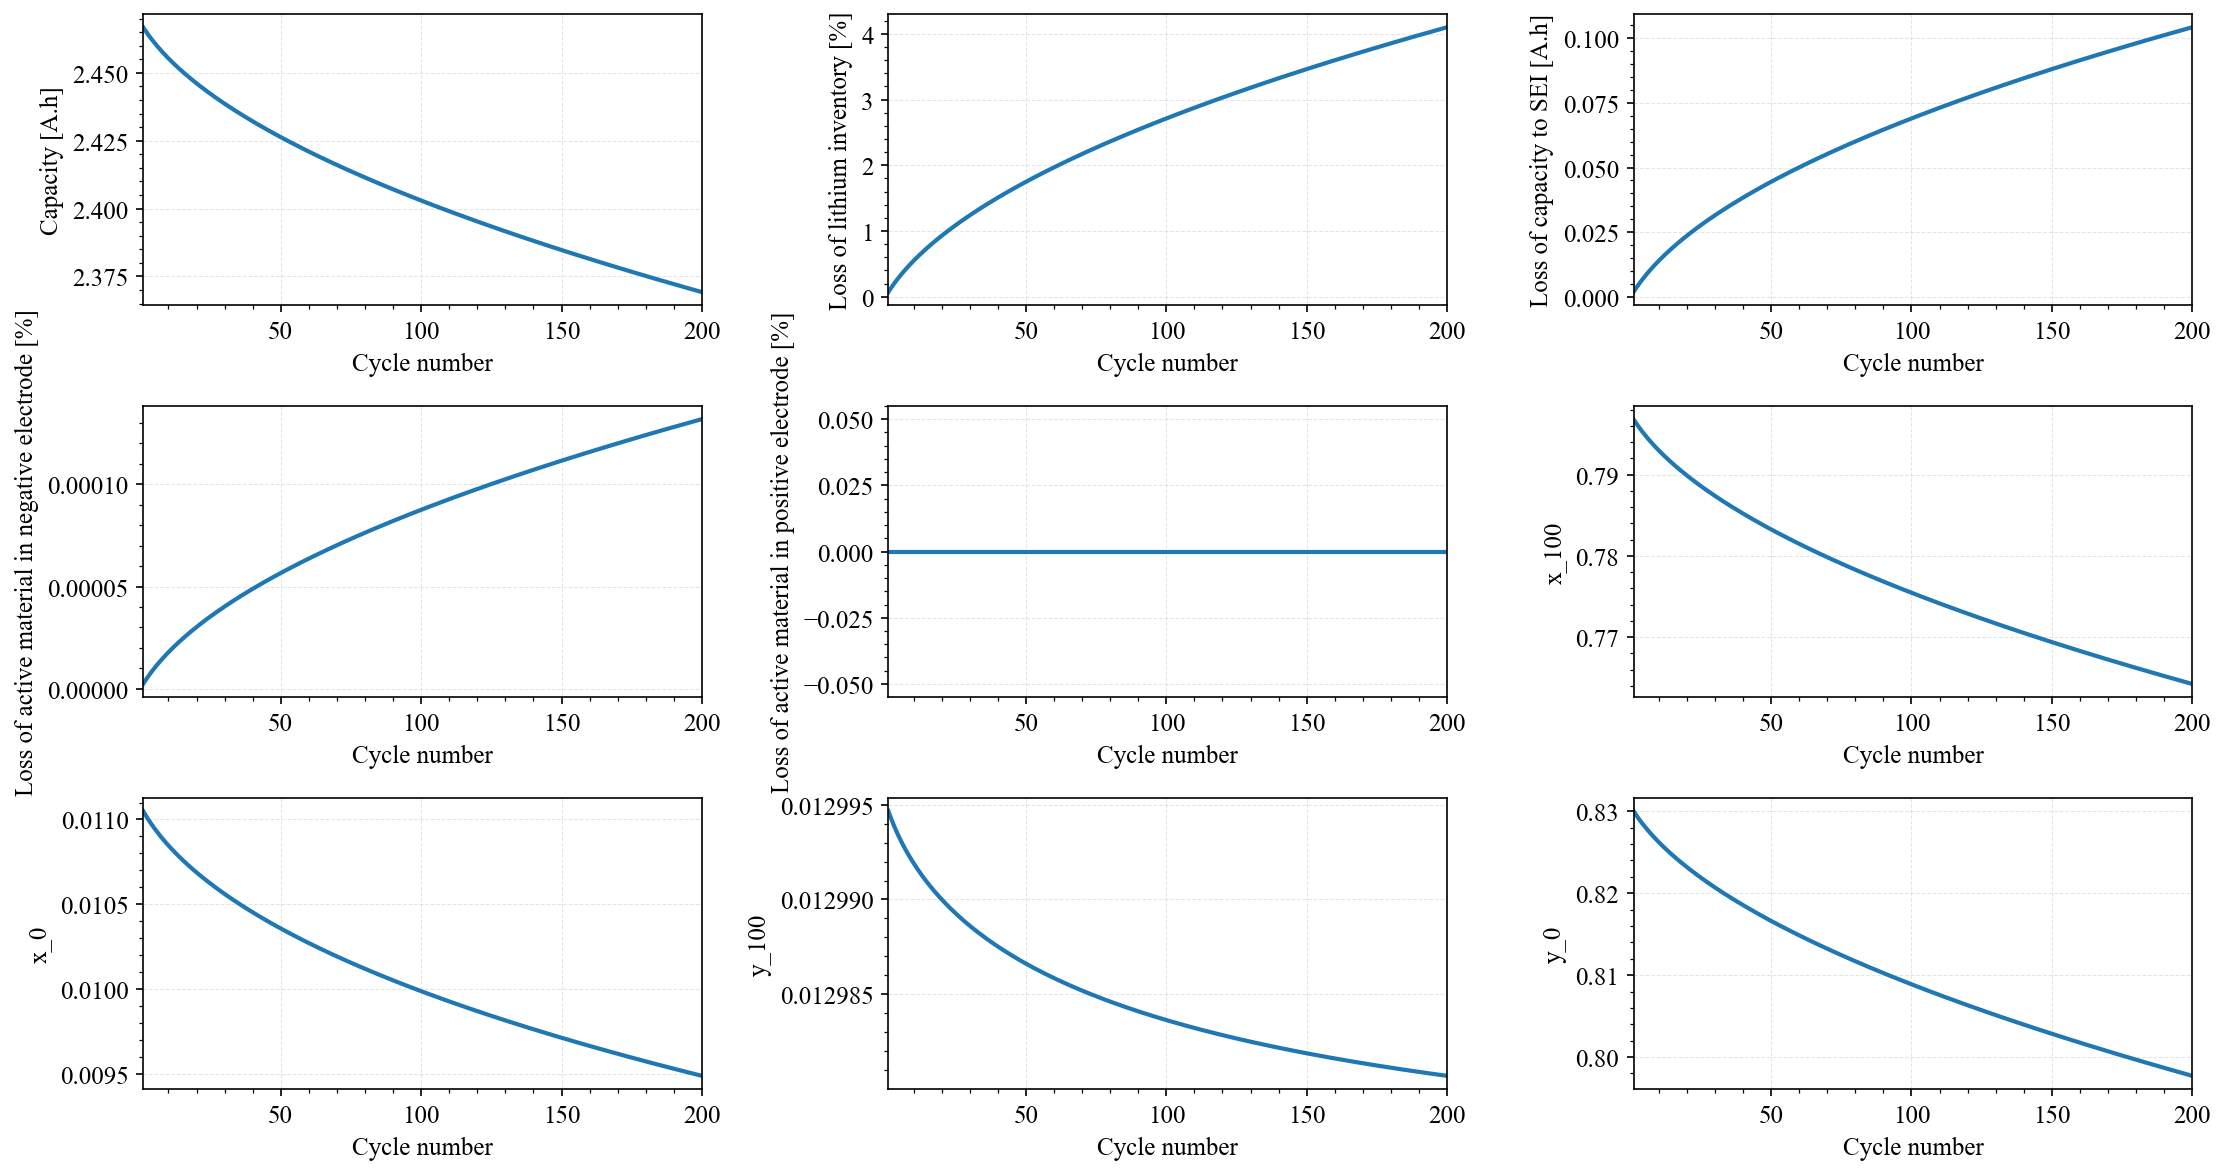

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [26]:
pybamm.plot_summary_variables(sol_long11)

In [24]:
yufiukkgk

NameError: name 'yufiukkgk' is not defined

In [ ]:
# SOC_0=0.5

# all_sumvars_dict3 = cycle_adaptive_simulation(spm, parameter_values, experiment3,SOC_0, save_at_cycles=1)

In [ ]:
# fig = plotc(all_sumvars_dict3,dfe);


In [ ]:
print(parameter_values.search("max"))
print(parameter_values.search("EC "))
print(parameter_values.search("plating"))
print(parameter_values.search("SEI"))
print(parameter_values.search("LAM"))
print(SOC_0)
print(Temp)


In [ ]:
print(eps_n_data)

In [ ]:
print(eps_p_data)

In [ ]:
# parameter_values.search("")

In [ ]:
# SOC_0=0
# all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [ ]:
# fig = plotc(all_sumvars_dict1,dfe);


In [ ]:

qdqwf


In [ ]:
sol_long=sol_long1
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
    Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,

In [ ]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
    
       }
savemat("Andrew_dissolution_Mar18.mat",mdic)

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,10))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"k")
    ax.plot(all_sumvars_dict3["Cycle number"],all_sumvars_dict3[name],"g")
    ax.set_title(split_long_string(name))
    if k ==2 or k==3:
        ax.set_ylim([2,4])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)

In [ ]:
# all_sumvars_dict1

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"],sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"],sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Throughput (Ah)")

ax = axes.flat[1]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"]/5,sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"]/5,sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Discharged capacity/Nominal Capacity (Ah/Ah)")



fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)




In [1]:
sol_long1.summary_variables.search("SEI")

NameError: name 'sol_long1' is not defined

In [ ]:
spm.variables.search("area")

In [ ]:
find / -type f -name '*.py' -exec grep -l "keyword" {} \;


In [ ]:
sol_long1["SEI"].entries[-1][1]

In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

# parameter_values = get_parameter_values()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        
   
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

parameter_values.search("negative el")

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
"Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
"Nominal cell capacity [A.h]":2.5,
"Maximum concentration in positive electrode [mol.m-3]":37500,
        
# Updating since February 2022        
"Negative electrode porosity":0.3,
"Positive electrode thickness [m]":5.45e-05,
# "Electrode width [m]" : 0.11,      
     
    }
)

cell = 152002

cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp


eps_n_data

 parameter_values.search("Reference temperature")

# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min",)
    ] *900,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment2 = pybamm.Experiment(
    [
        ("Rest for 24 hours",)
    ] *150,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment3 = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/20",
         "Rest for 10 min",
         "Discharge at 1C until 3.7V",
         "Rest for 80 min",)
    ] *800,
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment4 = pybamm.Experiment(
    [
        ("Rest for 24 hours",
)
    ] *200,
    termination="50% capacity",
#     cccv_handling="ode",
)


eps_p_data

Temp=45
# Temp=25

# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
#         "Positive electrode LAM constant proportional term [s-1]": 8.3747149e-08,#1.27152e-07
        "Positive electrode LAM constant proportional term [s-1]": 7.6504e-08,#10.0638e-08, #8e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":8.7598e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]": 4.352126e-16, #4.1964e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 3.6864e-21, #6.6582e-19, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 5997.629, #6.02602e+03, #1.87422275e+04,1.58777981e+04,
#         "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 1.3e03,    #1e06, #3.0e+05,
        "Lithium plating kinetic rate constant [m.s-1]":4.639e-10, #4.50936e-10,
        
        #Cathode disolution
#         "Positive electrode dissolution exchange current density": 6.243219e-4,
        "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        
        
    },
    check_already_exists=False,
)

# sim_long3 = pybamm.Simulation(spm, experiment=experiment3, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long3 = sim_long3.solve(initial_soc=0.5, save_at_cycles=20  )


 parameter_values.search("area")

# sim_long3.plot(
#     [
# #         "Negative particle surface concentration [mol.m-3]",
# #         "Electrolyte concentration [mol.m-3]",
#         "Positive particle surface concentration [mol.m-3]",
#         "Current [A]",
# #         "Negative electrode potential [V]",
# #         "Electrolyte potential [V]",
# #         "Positive electrode potential [V]",
#         "Terminal voltage [V]",
# #         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"

#     ]
# )

# pybamm.plot_summary_variables(sol_long3)

# summary_long3=sol_long3.summary_varabales







sim_long1 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long1 = sim_long1.solve(initial_soc=0.4, save_at_cycles=20  )

sim_long1.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
          "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
#         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"
#         "Loss of active material in positive electrode [%]",
#         "X-averaged positive electrode active material volume fraction change",
#         "Positive particle surface concentration",
#         "R-averaged positive particle concentration",
#         "Positive electrode surface potential difference",
#         "Positive electrode surface potential difference [V]"

        



        
    ]
)

pybamm.plot_summary_variables(sol_long1)

spm.param.timescale

sim_long11 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long11 = sim_long11.solve(initial_soc=0.9, save_at_cycles=20  )

sim_long11.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
        "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
        
    ]
)

pybamm.plot_summary_variables(sol_long11)

yufiukkgk



# SOC_0=0.5

# all_sumvars_dict3 = cycle_adaptive_simulation(spm, parameter_values, experiment3,SOC_0, save_at_cycles=1)

# fig = plotc(all_sumvars_dict3,dfe);


print(parameter_values.search("max"))
print(parameter_values.search("EC "))
print(parameter_values.search("plating"))
print(parameter_values.search("SEI"))
print(parameter_values.search("LAM"))
print(SOC_0)
print(Temp)


print(eps_n_data)

print(eps_p_data)

# parameter_values.search("")

# SOC_0=0
# all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

# fig = plotc(all_sumvars_dict1,dfe);



qdqwf


sol_long=sol_long1
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
    Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,

from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
    
       }
savemat("Andrew_dissolution_Mar18.mat",mdic)

esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,10))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"k")
    ax.plot(all_sumvars_dict3["Cycle number"],all_sumvars_dict3[name],"g")
    ax.set_title(split_long_string(name))
    if k ==2 or k==3:
        ax.set_ylim([2,4])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)

# all_sumvars_dict1

fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"],sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"],sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Throughput (Ah)")

ax = axes.flat[1]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"]/5,sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"]/5,sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Discharged capacity/Nominal Capacity (Ah/Ah)")



fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)




sol_long1.summary_variables.search("area")

spm.variables.search("area")

find / -type f -name '*.py' -exec grep -l "keyword" {} \;


sol_long1["SEI"].entries[-1][1]

